In [ ]:
import xarray as xr
import numpy as np
from PIL import Image as PILImage
from osgeo import gdal, osr, gdal_array
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

data=xr.open_dataset('./data/cloud3D_image.nc')
image = mpimg.imread('./data/PAN_reference.png')

import plotly
plotly.tools.set_credentials_file(username='mseymour24', api_key='dj5yHkhdjk9OXisXLJME')
import plotly.plotly as ply
import plotly.graph_objs as go

In [2]:
data

<xarray.Dataset>
Dimensions:            (i: 500, j: 500, x: 3, y: 500, z: 500)
Dimensions without coordinates: i, j, x, y, z
Data variables:
    band_0             (i, j) int32 ...
    nb_views           (i, j) int32 ...
    nodata             (i, j) int32 ...
    radius             (i, j) float32 ...
    secondary_1        (i, j) int32 ...
    secondary_2        (i, j) int32 ...
    dir_view_1_vector  (x, y, z) int32 ...
    dir_view_1_origin  (x, y, z) int32 ...
    dir_view_2_vector  (x, y, z) int32 ...
    dir_view_2_origin  (x, y, z) int32 ...
    dir_view_3_vector  (x, y, z) int32 ...
    dir_view_3_origin  (x, y, z) int32 ...
    coord_ECEF         (x, y, z) float64 ...

In [3]:
cloud3D = np.array(data.coord_ECEF)
x = cloud3D[0]
y = cloud3D[1]
z = cloud3D[2]
#print (np.shape(x))
nb_views=data.nb_views.to_pandas()
nb_views = np.array(nb_views)

In [4]:
SVM = gdal.Open('./data/clLabeledImage_SVM.tif')
classe = SVM.GetRasterBand(1).ReadAsArray()
classe = np.array(classe)
print (np.min(classe),np.max(classe))

2 4


In [7]:
start_x,start_y,w,h=100,200,100,100

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='utm', ellps='WGS84', datum='WGS84')
p = pyproj.transform(ecef, lla, x, y, z, radians=True)
#print (p)
px =np.array([p[0][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
py = np.array([p[1][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
pz = np.array([p[2][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
pclasse=np.array([classe[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])

In [8]:
#Plot
trace1 = go.Scatter3d(x=px.T,y=py.T,z=pz.T,mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=1,color=pclasse
    ))


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
    
)
fig = go.Figure(data=data, layout=layout)
ply.iplot(fig,filename='3DCloud1')

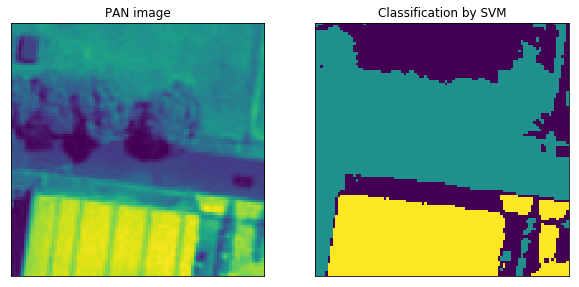

In [13]:
gs=GridSpec(1,2)
fig=plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(gs[0,0])
plt.title('PAN image')
plt.xticks(range(start_x,start_x+w))
plt.yticks(range(start_y,start_y+h))
plt.imshow(image[start_x:start_x+w,start_y:start_y+h])

ax1 = fig.add_subplot(gs[0,1])
plt.title('Classification by SVM')
plt.xticks(range(start_x,start_x+w))
plt.yticks(range(start_y,start_y+h))
plt.imshow(classe[start_x:start_x+w,start_y:start_y+h])
plt.show()